# Entire data analysis for LWFA plasma lens paper - simulations

This is the full script to analyze the two simulations presented in the paper **Reduction of the electron beam divergence of laser wakefield-accelerators by integrated plasma lenses** by *Y.-Y. Chang et al.*. Responsible for running and analyzing the simulations was *R. Pausch*. 

This jupyter notebook has been clean from all test code snippets and extensively commented. Since the raw (particle) data is in the TB range and not easily accessible, we use the jupyter magic command `%store` to keep results stored in this notebook. This makes this notebook a few hundred MB in size, but allows following our analysis. Code for reading in the raw data is still kept in this notebook, but save guarded by the boolean variable `reload_data`, which is set to `False`.

If you need to reload the data, you can access the entire simulation data from **Helmholtz-Zentrum Dresden - Rossendorf** www.hzdr.de. The simulations can be requested via the archiving ID `5616`. 

In [1]:
reload_data = False

__Comment:__

Initially, the plasma lens was called **DIC**. Thus, most variables still use the abbreviation `DIC` instead of `plasma_lens`. 

## load modules

In [2]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm

import scipy
import scipy.constants as const 
from scipy.signal import hilbert

import openpmd_api as io

import pandas as pd

In [3]:
for m in [np, mpl, scipy, io, pd]:
    print(m.__name__, m.__version__)


numpy 1.24.3
matplotlib 3.7.1
scipy 1.10.1
openpmd_api 0.15.1
pandas 2.0.2


In [4]:
# where is this notebook on summit (olcf.ornl)
!pwd

/gpfs/alpine/csc380/proj-shared/rpausch/notebooks


This notebook was executed via the juyter service on summit. If you recover the data later, please adjust paths accordingly. Here we keep the data structure as used on summit.  

## Central definitions

### colors

In [5]:
# color map
my_colors = mpl.colors.LinearSegmentedColormap.from_list("", ["white","midnightblue","orangered", "gold", "lemonchiffon"]) 

### simulation data path (on summit)

In [6]:
# path to simulations on ORNL summit

# simulation with plasma lens
sim_path_DIC = "/gpfs/alpine/proj-shared/csc380/rpausch/runs_LWFA/063_LWFA_Arie+DIC_fixed02/"

# simulation without plasma lense
sim_path_noDIC = "/gpfs/alpine/proj-shared/csc380/rpausch/runs_LWFA/064_LWFA_Arie+noDIC_fixed02/"


### simulation size and domain decomposition 

In [7]:
# simulation setup 

DELTA_T_SI = 1.39e-16 * 0.523427 # time step duration [s]
CELL_WIDTH_SI = 0.1772e-6 # cell width = Delta x [m]
CELL_HEIGHT_SI = 0.4430e-7 * 0.5 # cell height = Delta y [m]
CELL_DEPTH_SI = CELL_WIDTH_SI # cell depth = Delta z [m]

Nx, Ny, Nz = 768, 4608, 768 # number of cells in x,y,z
GPUx, GPUy, GPUz = 6, 8, 8 # number of GPUs used for domain decomposition in x,y,z
E_max_hist = 800 # maximum energy bin in energy histogram in-situ plugin (see first line of raw data or submit.cfg file) [MeV]

In [8]:
# compute simulated volume (minus moving window layer) to recover density from energy histogram

volume = Nx * CELL_WIDTH_SI * (GPUy-1.)/GPUy * Ny * CELL_HEIGHT_SI * Nz * CELL_DEPTH_SI

### laser parameters

In [9]:
# laser parameters 
lambda_0 = 800.0e-9 # laser wavelnegth (see laser.param) [m]
omega_0 = 2. * np.pi * const.c / lambda_0  # laser frequency [1/s]

E_to_a0 = const.elementary_charge / const.electron_mass / const.speed_of_light / omega_0 # conversion factor from electriv field [V/m] to unitless a_0

## energy histogram data - also used for density reconstruction 

### data loading

In [10]:
if reload_data:
    # there are two electron species: 
    # e: background
    # en: tightly bound electrons at Nitrogen N^5+ that will be injected during self-truncated ionization injection (STII)
    
    # with plasma lens
    hist_raw_e_DIC = np.loadtxt(sim_path_DIC + "/simOutput/e_energyHistogram_all.dat")
    hist_raw_en_DIC = np.loadtxt(sim_path_DIC + "/simOutput/en_energyHistogram_all.dat")
    
    # without plasma lense
    hist_raw_e_noDIC = np.loadtxt(sim_path_noDIC + "/simOutput/e_energyHistogram_all.dat")
    hist_raw_en_noDIC = np.loadtxt(sim_path_noDIC + "/simOutput/en_energyHistogram_all.dat")

    # store data
    %store hist_raw_e_DIC
    %store hist_raw_en_DIC
    
    %store hist_raw_e_noDIC
    %store hist_raw_en_noDIC

# retrieve data if stored in notebook
%store -r hist_raw_e_DIC
%store -r hist_raw_en_DIC

%store -r hist_raw_e_noDIC
%store -r hist_raw_en_noDIC

### analyze energy evolution of both simulations (not used in manuscript)

In [11]:
# energy bins used in the in-situ plugin 
E_bins = np.linspace(0.0, E_max_hist, 1024) # [MeV]

# positions along laser propagation where the data is taken
# z (in PIConGU actially y) = time step * time step duration * speed of light:
pos_hist = hist_raw_e_DIC[:, 0] * DELTA_T_SI * const.c # [m] # !!! assuming same number of iterations for all simulations and data sets 

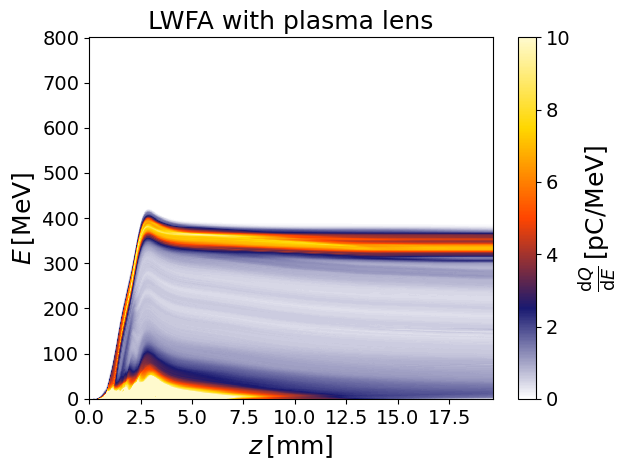

In [12]:
# plot energy evolution of STII injection with plasma lens

plt.title("LWFA with plasma lens", fontsize=18)

plt.pcolormesh(pos_hist / 1e-3, E_bins, hist_raw_en_DIC[:, 2:-2].T * const.elementary_charge / 1e-12 / (E_bins[1] - E_bins[0]), 
               vmax=10,#norm=mpl.colors.LogNorm(vmin=1e3, vmax=1e9), 
               cmap=my_colors)
cb = plt.colorbar()

plt.xlabel(r"$z \, \mathrm{[mm]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel(r"$E \, \mathrm{[MeV]}$", fontsize=18)
plt.yticks(fontsize=14)

cb.set_label(r"$\frac{\mathrm{d}Q}{\mathrm{d} E}\, \mathrm{[pC/MeV]}$", fontsize=18)
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)
    
plt.tight_layout()
plt.show()

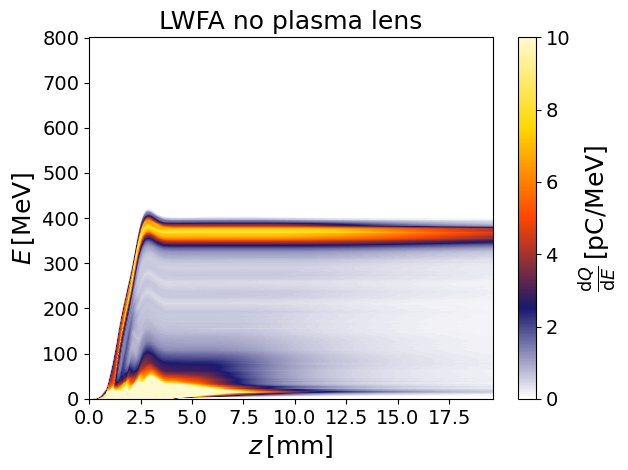

In [13]:
# plot energy evolution of STII injection without plasma lens

plt.title("LWFA no plasma lens", fontsize=18)

plt.pcolormesh(pos_hist / 1e-3, E_bins, hist_raw_en_noDIC[:, 2:-2].T * const.elementary_charge / 1e-12 / (E_bins[1] - E_bins[0]), 
               vmax=10,#norm=mpl.colors.LogNorm(vmin=1e3, vmax=1e9), 
               cmap=my_colors)
cb = plt.colorbar()

plt.xlabel(r"$z \, \mathrm{[mm]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel(r"$E \, \mathrm{[MeV]}$", fontsize=18)
plt.yticks(fontsize=14)

cb.set_label(r"$\frac{\mathrm{d}Q}{\mathrm{d} E}\, \mathrm{[pC/MeV]}$", fontsize=18)
for i in cb.ax.get_yticklabels():
    i.set_fontsize(14)
    
plt.tight_layout()
plt.show()

### recover density from energy histogram 

The total number of electrons (last bin of the histogram data) divided by the simulation volume (over which the energy histogram plugin works) is the number density, this relationship was used to reconstruct the density and avoid relying on the implemented C++ functions in `density.param`.  

In [14]:
# with plasma lens
density_DIC = hist_raw_e_DIC[:, -1] / volume

# without plasma lens
density_noDIC = hist_raw_e_noDIC[:, -1] / volume

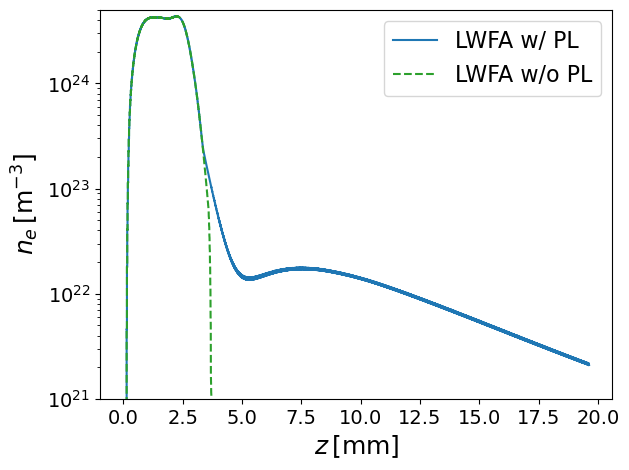

In [15]:
# plot density of both simulations with and without plasma lens (=PL)

plt.plot(pos_hist / 1e-3, density_DIC, color="C0", label="LWFA w/ PL")

plt.plot(pos_hist / 1e-3, density_noDIC, "--", color="C2", label="LWFA w/o PL")


plt.xlabel(r"$z \, \mathrm{[mm]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel(r"$n_e \, \mathrm{[m^{-3}]}$", fontsize=18)
plt.yticks(fontsize=14)

#plt.ylim(0,5e24)
plt.yscale("log")
plt.ylim(1e21,5e24)

plt.legend(loc=1, fontsize=16)
plt.tight_layout()
plt.show()

Please be aware that the LWFA stage (high density) differs slightly from the experiment. Because the simulation parameter scan for the Laval nozzle used in the experiment would have required many large scale simulations, we relied on a slightly larger nozzle setup that had an already characterized injection dynamic (in simulation) and added the measured plasma lens density profile after the end of the main nozzle density. 

## analyze particle data: divergence, emittance, energy

To analyze the evolution of beam divergence inside the plasma lens, all particles are read at each output time step and statistically analyzed.

### data loading

In [16]:
def readParticleData(sim_path):
    serie = io.Series(sim_path + "/simOutput/openPMD/simOutput_en_%T.bp", access=io.Access_Type.read_only)

    theta_std = np.zeros(len(serie.iterations)) # divergence [rad]
    energy_mean = np.zeros(len(serie.iterations)) # mean energy [eV]
    emittance = np.zeros(len(serie.iterations)) # beam emittance [mm mrad]


    for index, i in enumerate(serie.iterations):
        #print(type(i))
        it = serie.iterations[i]
        h_en = it.particles['en_all']

        # particle weighting
        w_h = h_en['weighting'][io.Record_Component.SCALAR]
        w = w_h[:]
        w_unitSI = w_h.unit_SI
        serie.flush()
        w *= w_unitSI

        # momentum x
        px_h = h_en['momentum']['x']
        px = px_h[:]
        px_unitSI = px_h.unit_SI
        serie.flush()
        px *= px_unitSI / w

        # momentum y
        py_h = h_en['momentum']['y']
        py = py_h[:]
        py_unitSI = py_h.unit_SI
        serie.flush()
        py *= py_unitSI / w

        # momentum z
        pz_h = h_en['momentum']['z']
        pz = pz_h[:]
        pz_unitSI = pz_h.unit_SI
        serie.flush()
        pz *= pz_unitSI / w

        # in cell position x
        x_h = h_en['position']['x']
        x = x_h[:]
        x_unitSI = x_h.unit_SI 

        # global cell position x 
        xO_h = h_en['positionOffset']['x']
        xO = xO_h[:]
        xO_unitSI = x_h.unit_SI  

        # flush openPMD reader
        serie.flush()

        # convert data:
        
        # position in m
        x *= x_unitSI
        x += xO * xO_unitSI

        # pointing angle [rad]
        theta = np.arctan2(px, py)
        
        # energy of particle [eV]
        E = np.sqrt((px**2 + py**2 + pz**2) * const.c**2 + const.electron_mass**2 * const.c**4) / const.elementary_charge

        # filter: only use electrons above 250 MeV for analysis
        energyFilter = np.greater_equal(E, 250e6)

        # definition: std = sqrt(mean(x)), where x = abs(a - a.mean())**2.
        # compute divergence
        theta_mean = np.average(theta[energyFilter], weights=w[energyFilter])
        theta_std[index] = np.sqrt(np.average(np.abs(theta[energyFilter] - theta_mean)**2 , weights=w[energyFilter]))

        # compute mean energy 
        energy_mean[index] = np.average(E[energyFilter], weights=w[energyFilter])

        gamma_beta = energy_mean[index] / 0.511e6 # approx beta * gamma
        # verbose output 
        print(index, "/", len(serie.iterations), " --> beta * gamma = ", gamma_beta)

        # compute emittance
        # epsilon = sqrt( <x^2> * <theta_x^2> - (<x * theta>^2) )
        x_mean = np.average(x[energyFilter], weights=w[energyFilter])

        mean_x_square = np.average((x[energyFilter] - x_mean)**2, weights=w[energyFilter])
        mean_theta_square = np.average((theta[energyFilter] - theta_mean)**2, weights=w[energyFilter])
        mean_x_theta = np.average((x[energyFilter] - x_mean) * (theta[energyFilter] - theta_mean), weights=w[energyFilter])

        # there is an error in Sophie Rudats thesis - normalized emittance is just epislion_norm = beta * gamma * emittance not (beta * gamma)^2 * emittance
        emittance[index] = gamma_beta * np.sqrt(mean_x_square * mean_theta_square - mean_x_theta**2) / 1e-3 / 1e-3 # [mm mrad]

    # position along laser axis of data    
    z_in_mm = np.array(serie.iterations) * DELTA_T_SI * const.c / 1e-3

    return theta_std, energy_mean, emittance, z_in_mm

In [17]:
# read particle data of simulation with plasma lens

if reload_data:
    theta_std_DIC, energy_mean_DIC, emittance_DIC, z_in_mm = readParticleData(sim_path_DIC)

    %store theta_std_DIC
    %store energy_mean_DIC
    %store emittance_DIC
    %store z_in_mm
    
%store -r theta_std_DIC
%store -r energy_mean_DIC
%store -r emittance_DIC
%store -r z_in_mm

In [18]:
# read particle data of simulation without plasma lens

if reload_data:
    theta_std_noDIC, energy_mean_noDIC, emittance_noDIC, _ = readParticleData(sim_path_noDIC)

    %store theta_std_noDIC
    %store energy_mean_noDIC
    %store emittance_noDIC

%store -r theta_std_noDIC
%store -r energy_mean_noDIC
%store -r emittance_noDIC

### plot parameters of beam evolution 

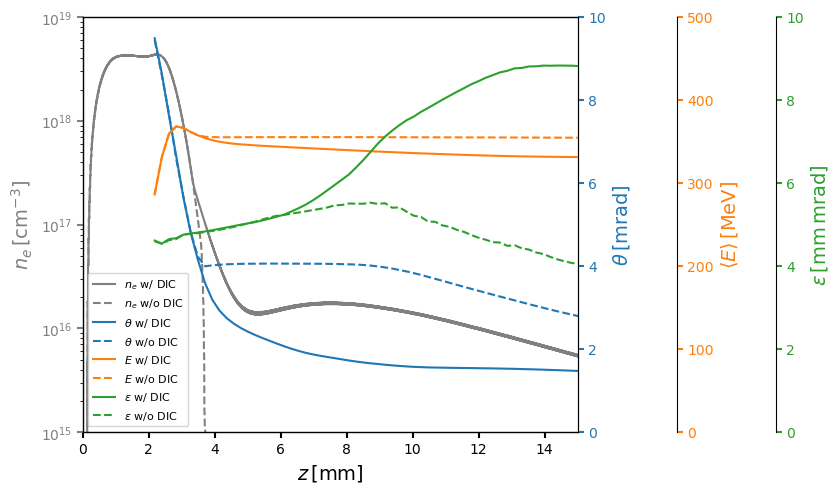

In [19]:
fig, ax = plt.subplots(figsize=(9,5))
fig.subplots_adjust(right=0.65, bottom=0.15, left=0.1, top=0.98)

# ax = density 
twin1 = ax.twinx() # divergence
twin2 = ax.twinx() # mean energy 
twin3 = ax.twinx() # emittance 

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))
twin3.spines.right.set_position(("axes", 1.4))

p1a, = ax.plot(pos_hist / 1e-3, density_DIC / 1e6, color="gray", label=r"$n_e$ w/ DIC")
p1b, = ax.plot(pos_hist / 1e-3, density_noDIC / 1e6, "--", color="gray", label=r"$n_e$ w/o DIC")


p2a, = twin1.plot(z_in_mm, theta_std_DIC/1e-3, color="C0", label=r"$\theta$ w/ DIC")
p2b, = twin1.plot(z_in_mm, theta_std_noDIC/1e-3, "--", color="C0", label=r"$\theta$ w/o DIC")


p3a, = twin2.plot(z_in_mm, energy_mean_DIC/1e6, color="C1", label=r"$E$ w/ DIC ")
p3b, = twin2.plot(z_in_mm, energy_mean_noDIC/1e6, "--", color="C1", label=r"$E$ w/o DIC")

p4a, = twin3.plot(z_in_mm, emittance_DIC, "-", color="C2", label = r"$\epsilon$ w/ DIC")
p4b, = twin3.plot(z_in_mm, emittance_noDIC, "--", color="C2", label = r"$\epsilon$ w/o DIC")


tkw = dict(size=4, width=1.5)
ax.tick_params(axis='x', **tkw)


ax.set_xlim(0, 15)
ax.set_xlabel(r"$z \, \mathrm{[mm]}$", fontsize=14)

ax.set_yscale("log")
ax.set_ylim(1e15, 1e19)
ax.set_ylabel(r"$n_e \, \mathrm{[cm^{-3}]}$", fontsize=14)
ax.yaxis.label.set_color(p1a.get_color())
ax.tick_params(axis='y', colors=p1a.get_color(), **tkw)


#twin1.set_yscale("log")
twin1.set_ylim(0.0, 10)
twin1.set_ylabel(r"$\theta \, \mathrm{[mrad]}$", fontsize=14)
twin1.yaxis.label.set_color(p2a.get_color())
twin1.tick_params(axis='y', colors=p2a.get_color(), **tkw)


twin2.set_ylim(0, 500)
twin2.set_ylabel(r"$\left< E \right> \, \mathrm{[MeV]}$", fontsize=14)
twin2.yaxis.label.set_color(p3a.get_color())
twin2.tick_params(axis='y', colors=p3a.get_color(), **tkw)


twin3.set_ylim(0, 10)
twin3.set_ylabel(r"$\epsilon \, \mathrm{[mm \, mrad]}$", fontsize=14)
twin3.yaxis.label.set_color(p4a.get_color())
twin3.tick_params(axis='y', colors=p4a.get_color(), **tkw)

ax.legend(handles=[p1a, p1b, p2a, p2b, p3a, p3b, p4a, p4b], loc=3, fontsize=8)

plt.show()

### Why does the divergence and emittance drop for w/o DIC?

**Answer:** Because due to the $250 \, \mathrm{MeV}$ energy filter, particles are dropped from the statistical analysis (either due to slow down or to leaving the simulation box) resulting in a decease of divergence (and thus emittance) - details see analysis below

In [20]:
if reload_data:
    en_mp_count_noDIC = np.loadtxt(sim_path_noDIC + "/simOutput/en_macroParticlesCount.dat")
    
    %store en_mp_count_noDIC
    
%store -r en_mp_count_noDIC

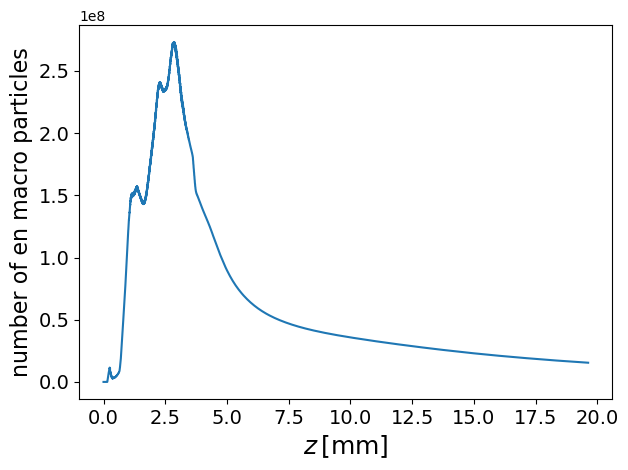

In [21]:
plt.ylabel("number of en macro particles", fontsize=16)
plt.yticks(fontsize=14)

plt.xlabel("$z\, \mathrm{[mm]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.plot(en_mp_count_noDIC[:, 0] * DELTA_T_SI * const.c /1e-3, en_mp_count_noDIC[:, 1])

plt.tight_layout()
plt.show()

One can see, that particles are lost, but the total number of `en` macro particle reduction does not explain the sharp reduction of divergence and emittance at $z \approx 10\, \mathrm{mm}$. We will look at the number of particles with $E \geq 250 \, \mathrm{MeV}$ as used in the particle analysis, using the energy histogram plugin data. 

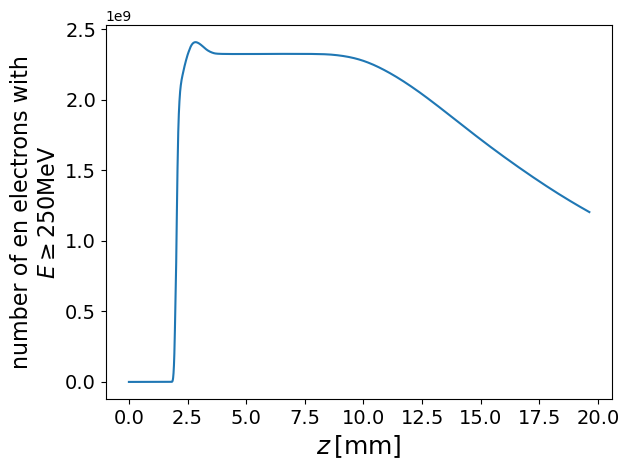

In [22]:
plt.ylabel("number of en electrons with\n"+r"$E\geq 250 \mathrm{MeV}$", fontsize=16)
plt.yticks(fontsize=14)

plt.xlabel("$z\, \mathrm{[mm]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.plot(pos_hist / 1e-3, np.sum(hist_raw_en_noDIC[:, 2:-2][:, np.greater(E_bins, 250)], axis=1))

plt.tight_layout()
plt.show()

__explanation for divergence reduction:__

The applied energy filter $E > 250 \mathrm{MeV}$ will clip particles starting at $z \approx 10 \, \mathrm{mm}$.

## get laser $a_0$ evolution and maximum focusing field

### data loading

In [23]:
def readFieldData(sim_path):
    
    serie = io.Series(sim_path + "/simOutput/openPMD/simOutput_fields_%T.bp", access=io.Access_Type.read_only)

    # E field in polarization direction along propagation axis at center for each ouput step
    Ex_overTime = np.zeros((len(serie.iterations), 4032))

    # maximum focusing force for each ouput step    
    Fmax_overTime = np.zeros(len(serie.iterations))
    
    # limit of y read out for laser (this is just a 
    #y_max_cut = 2799

    for i , it in enumerate(serie.iterations):
        it_int = it
        it = serie.iterations[it]
        
        # electric field in x - for laser strength
        h = it.meshes['E']['x']
        Ex = h[768//2, :, 0]
        Ex_unitSI = h.unit_SI

        # electric field in z - for focusing force 
        h = it.meshes['E']['z']
        Ez = h[:, :, 0]
        Ez_unitSI = h.unit_SI

        # magnetic field in x - for focusing force         
        h = it.meshes['B']['x']
        Bx = h[:, :, 0]
        Bx_unitSI = h.unit_SI    

        # read data in
        serie.flush()
        
        # convert data
        Ex *= Ex_unitSI
        Ex_overTime[i, :] = Ex

        Ez *= Ez_unitSI
        Bx *= Bx_unitSI

        # filter region of selection for focusing force to avoid artifacts from the laser field 
        F = const.elementary_charge * (Ez - const.c *Bx)
        if it_int <=180000:
            y_max_cut = 2799
            z_max_cut = -32
        else: 
            y_max_cut = 500
            z_max_cut = Nz//3

        Fmax_overTime[i] = np.amax(np.abs(F[32:z_max_cut, 32:y_max_cut ]))
        
    a0_evol = np.amax(np.abs(hilbert(Ex_overTime[:, :], axis=1)) * E_to_a0, axis=1)        

    z_in_mm_fields = np.array(serie.iterations) * DELTA_T_SI * const.c / 1e-3
        
    return Ex_overTime, Fmax_overTime, a0_evol, z_in_mm_fields
    


In [24]:
# read field data for with plasma lens
if reload_data:
    
    Ex_overTime_DIC, Fmax_overTime_DIC, a0_evol_DIC, z_in_mm_fields = readFieldData(sim_path_DIC)
    
    %store Ex_overTime_DIC
    %store Fmax_overTime_DIC
    %store a0_evol_DIC
    %store z_in_mm_fields
    
%store -r Ex_overTime_DIC
%store -r Fmax_overTime_DIC
%store -r a0_evol_DIC
%store -r z_in_mm_fields


In [25]:
# read field data for with out plasma lens
if reload_data:

    Ex_overTime_noDIC, Fmax_overTime_noDIC, a0_evol_noDIC, _ = readFieldData(sim_path_noDIC)
    
    %store Ex_overTime_noDIC
    %store Fmax_overTime_noDIC
    %store a0_evol_noDIC 

%store -r Ex_overTime_noDIC
%store -r Fmax_overTime_noDIC
%store -r a0_evol_noDIC

### plot laser strength and focusing force results 

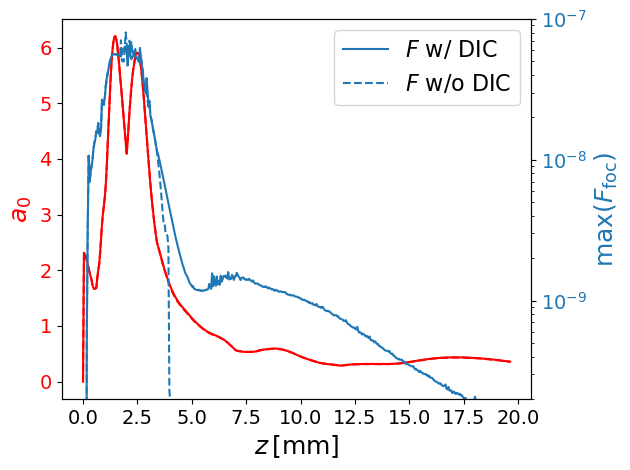

In [26]:
plt.xlabel(r"$z \, \mathrm{[mm]}$", fontsize=18)
plt.xticks(fontsize=14)



plt.ylabel(r"$a_0$", fontsize=18, color="red")
plt.yticks(fontsize=14, color="red")

plt.plot(z_in_mm_fields, a0_evol_DIC, "-", color="red", label=r"$a_0$ w/ DIC")
plt.plot(z_in_mm_fields, a0_evol_noDIC, "--", color="red", label=r"$a_0$ w/o DIC")


plt.twinx()

plt.ylabel(r"$\mathrm{max}(F_\mathrm{foc})$", fontsize=18, color="C0")
plt.yticks(fontsize=14, color="C0")

plt.plot(z_in_mm_fields, Fmax_overTime_DIC, "-", color="C0", label=r"$F$ w/ DIC")
plt.plot(z_in_mm_fields[:100], Fmax_overTime_noDIC[:100], "--", color="C0", label=r"$F$ w/o DIC")

plt.yscale("log")
plt.ylim(2e-10, 1e-7)


plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

## extract representative snapshots from LWFA w/ DIC

In [27]:
def getSnapshot(iteration_int):
    serie = io.Series(sim_path_DIC + "/simOutput/openPMD/simOutput_fields_%T.bp", access=io.Access_Type.read_only)

    it = serie.iterations[iteration_int]
    h = it.meshes['e_all_chargeDensity'][io.Mesh_Record_Component.SCALAR]
    n_e = h[:, :, 0]
    n_e_unitSI = h.unit_SI

    h = it.meshes['en_all_chargeDensity'][io.Mesh_Record_Component.SCALAR]
    n_en = h[:, :, 0]
    n_en_unitSI = h.unit_SI

    h = it.meshes['E']['z']
    Ez = h[:, :, 0]
    Ez_unitSI = h.unit_SI

    h = it.meshes['B']['x']
    Bx = h[:, :, 0]
    Bx_unitSI = h.unit_SI

    h = it.meshes['E']['x']
    Ex = h[:, :, 0]
    Ex_unitSI = h.unit_SI

    serie.flush()
    n_e *= n_e_unitSI / const.elementary_charge * -1.
    n_en *= n_en_unitSI / const.elementary_charge * -1.

    Ez *= Ez_unitSI
    Bx *= Bx_unitSI

    Ex *= Ex_unitSI 

    F = const.elementary_charge * (Ez - const.c *Bx)

    a0 = np.abs(hilbert(Ex[:, :], axis=0)) * E_to_a0
    
    return F, n_e, n_en, a0

### data loading iteration 180k

In [28]:
if reload_data:
    F_180k, n_e_180k, n_en_180k, a0_180k = getSnapshot(180000)

    %store F_180k
    %store n_e_180k
    %store n_en_180k
    %store a0_180k
    
%store -r F_180k
%store -r n_e_180k
%store -r n_en_180k
%store -r a0_180k


### plot iteration 180k 

**define** axis positions for `pcolormesh` plots 

In [29]:
Nz_field, Ny_field = n_en_180k.shape
z_field = (np.arange(Nz_field) - Nz_field//2) * CELL_WIDTH_SI 
y_field = np.arange(Ny_field) * CELL_HEIGHT_SI - 5.2e-5

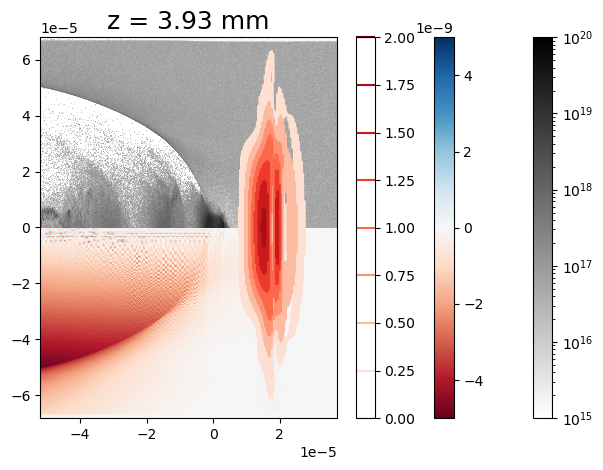

In [30]:
plt.title("z = {:1.2f} mm".format(180e3 * DELTA_T_SI * const.c / 1e-3), fontsize=18)


plt.pcolormesh(y_field, z_field[Nz_field//2:], (n_e_180k+ n_en_180k)[Nz_field//2:, :]/1e6, cmap=plt.cm.gray_r,  norm=LogNorm(vmin=1e15, vmax=1e20))
plt.colorbar()

F_lim = 5e-9
plt.pcolormesh(y_field, z_field[:Nz_field//2], F_180k[0:Nz_field//2, :], cmap=plt.cm.RdBu, vmin=-F_lim, vmax=+F_lim )
plt.colorbar()

plt.contour(y_field, z_field, a0_180k, cmap=plt.cm.Reds,)
plt.colorbar()

plt.tight_layout()
plt.show()

### data loading iteration 450k

In [31]:
if reload_data:
    F_450k, n_e_450k, n_en_450k, a0_450k = getSnapshot(450000)

    %store F_450k
    %store n_e_450k
    %store n_en_450k
    %store a0_450k
    
%store -r F_450k
%store -r n_e_450k
%store -r n_en_450k
%store -r a0_450k

### plot iteration 450k 

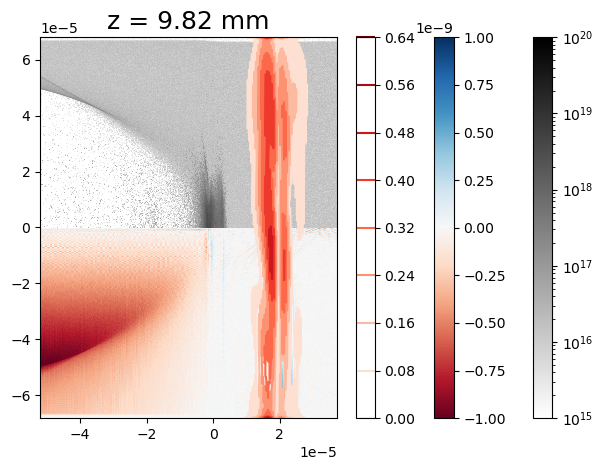

In [32]:
plt.title("z = {:1.2f} mm".format(450e3 * DELTA_T_SI * const.c / 1e-3), fontsize=18)
plt.pcolormesh(y_field, z_field[Nz_field//2:], (n_e_450k+ n_en_450k)[Nz_field//2:, :]/1e6, cmap=plt.cm.gray_r,  norm=LogNorm(vmin=1e15, vmax=1e20))
plt.colorbar()

F_lim = 1e-9
plt.pcolormesh(y_field, z_field[:Nz_field//2], F_450k[0:Nz_field//2, :], cmap=plt.cm.RdBu, vmin=-F_lim, vmax=+F_lim )
plt.colorbar()

plt.contour(y_field, z_field, a0_450k, cmap=plt.cm.Reds)
plt.colorbar()

plt.tight_layout()
plt.show()


### data loading iteration 100k

In [33]:
if reload_data:
    F_100k, n_e_100k, n_en_100k, a0_100k = getSnapshot(100000)

    %store F_100k
    %store n_e_100k
    %store n_en_100k
    %store a0_100k
    
%store -r F_100k
%store -r n_e_100k
%store -r n_en_100k
%store -r a0_100k

### plot iteration 100k 

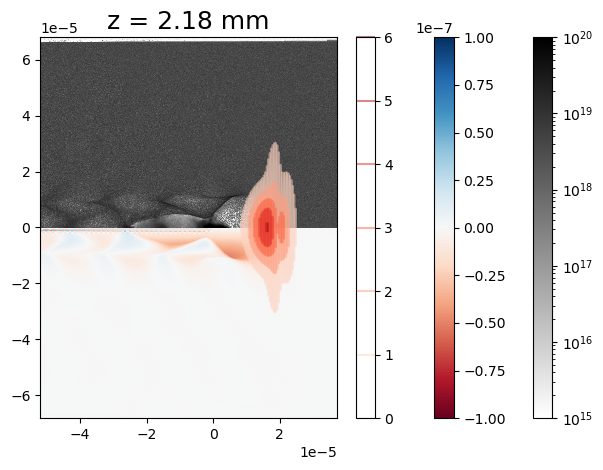

In [34]:
plt.title("z = {:1.2f} mm".format(100e3 * DELTA_T_SI * const.c / 1e-3), fontsize=18)
plt.pcolormesh(y_field, z_field[Nz_field//2:], (n_e_100k+ n_en_100k)[Nz_field//2:, :]/1e6, cmap=plt.cm.gray_r,  norm=LogNorm(vmin=1e15, vmax=1e20))
plt.colorbar()

F_lim = 1e-7
plt.pcolormesh(y_field, z_field[:Nz_field//2], F_100k[0:Nz_field//2, :], cmap=plt.cm.RdBu, vmin=-F_lim, vmax=+F_lim )
plt.colorbar()

plt.contour(y_field, z_field, a0_100k, cmap=plt.cm.Reds,  levels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], 
            alpha=0.5)
plt.colorbar()

plt.tight_layout()
plt.show()

## Compute theoretical focusing force

### read Fluent simulation data to get density profile 

In [35]:
if reload_data:
    df=pd.read_csv(r'wedge_y_4.25mm_density_on_axis.txt')
    x_fluent=df.values[:,1]*1.e3 # axis, mm
    y_fluent=df.values[:,4]*1.5e20 # gas density, cm^-3
    
    %store x_fluent
    %store y_fluent
    
%store -r x_fluent
%store -r y_fluent

### compute focusing strength based on simple assumptions 

In [36]:
# this code block is written by Y.-Y- Chang and commented by R. Pausch

#select region to plot via array index 
index_min=70
index_max=212

# convert gas density to electron number density (x2 since Helium has two electrons)
ne=y_fluent*2

# laser and plasma parameters
sigma_z=5e-6 # meter
lambda_p=3.34e6/np.sqrt(ne)*1e-2  # meter
kp=2*np.pi/lambda_p

# helper value for laser focusing force
ita=np.sqrt(2*np.pi)*kp*sigma_z*np.exp(-(kp**2*sigma_z**2)/2)

# bunch parameters 
gamma=400 # electron gamma factor

# laser parameters 
a0=2 # normalized laser strength                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
w0=15e-6 # laser spot size [meter]
Z_R=2.2e-3 # Rayleigh length [meter]

d=5e-6  # the distance from the electron bunch to the laser center [meter]

re=2.9e-15 # classical electron radius [meter]

ne0=2.e16 # base density 
kp0=2*np.pi/(3.34e6/np.sqrt(ne0)*1e-2) # base k value 

# The K factor for the laser plasma lens
K_laser=ita*a0**2*np.sin(kp0*d)/(gamma*w0**2)*Z_R**2/(x_fluent*1.e-3)**2 

# The K factor for passive plasma lens
K_passive=2*np.pi*re*ne*1e6/gamma

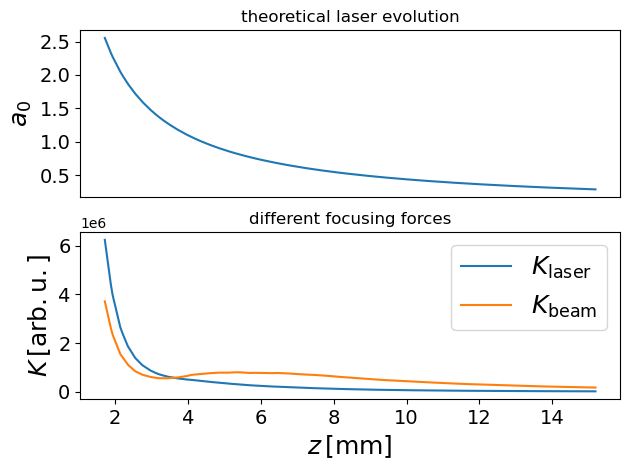

In [37]:
plt.subplot(211)
plt.title("theoretical laser evolution")
plt.plot(x_fluent[index_min:index_max],
         np.sqrt(a0**2*Z_R**2/(x_fluent[index_min:index_max]*1.e-3)**2))
plt.ylabel('$a_0$', fontsize = 18)
plt.yticks(fontsize=14)
plt.xticks([]) # same x-axis, thus no extra label 

plt.subplot(212)
plt.title("different focusing forces")
plt.plot(x_fluent[index_min:index_max],
         K_laser[index_min:index_max], 
        label=r"$K_\mathrm{laser}$")

plt.plot(x_fluent[index_min:index_max],
         K_passive[index_min:index_max],
         label=r"$K_\mathrm{beam}$")

plt.xlabel(r'$z \,\mathrm{[mm]}$', fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel(r"$K\, \mathrm{[arb.u.]}$", fontsize=18)
plt.yticks(fontsize=14)

plt.legend(loc=1, fontsize=18)

plt.tight_layout()
plt.show()

# Final plot for paper

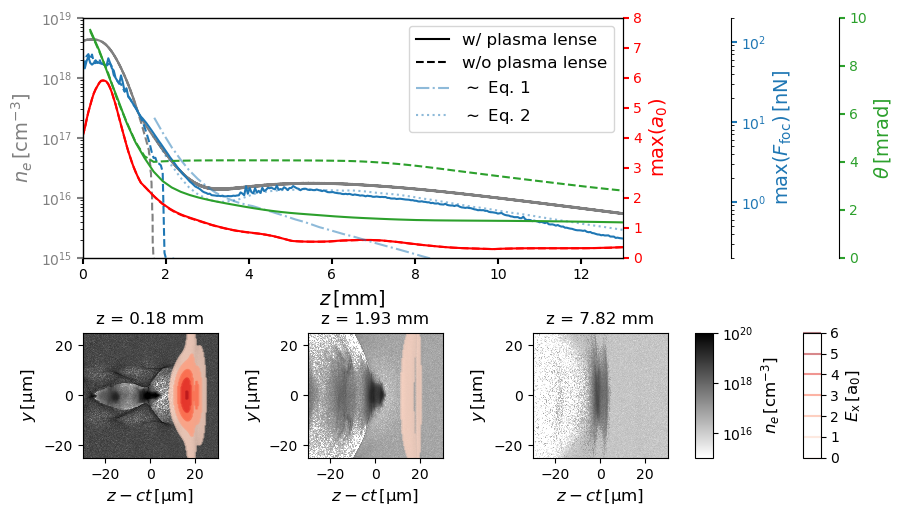

In [39]:
fig, ax = plt.subplots(figsize=(9,5))
fig.subplots_adjust(right=0.70, bottom=0.5, left=0.1, top=0.98)

# shift z position (PIConGPU y position) from zero being the start of the simulation to zero being the center of the gas jet (as used in experimental plots) 
x_offset = 2 # shift [mm]

# ax = density 
twin1 = ax.twinx() # a_0 value
twin2 = ax.twinx() # forces 
twin3 = ax.twinx() # divergence 

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.2))
twin3.spines.right.set_position(("axes", 1.4))

# density plots
p1a, = ax.plot(pos_hist / 1e-3 - x_offset, density_DIC / 1e6, color="gray", label=r"$n_e$ w/ DIC")
p1b, = ax.plot(pos_hist / 1e-3 - x_offset, density_noDIC / 1e6, "--", color="gray", label=r"$n_e$ w/o DIC")

# add label without lines to indicate w/ and w/o plasma lens
p_DIC, = ax.plot([-1, -2] , [0,0],  "-",color="black", label=r"w/ plasma lense")
p_noDIC, = ax.plot([-1, -2] , [0,0], "--",color="black",  label=r"w/o plasma lense")

# plot laser evolution
p2a, = twin1.plot(z_in_mm_fields - x_offset, a0_evol_DIC, "-", color="red", label=r"$a_0$ w/ DIC")
p2b, = twin1.plot(z_in_mm_fields - x_offset, a0_evol_noDIC, "--", color="red", label=r"$a_0$ w/o DIC")

# plot focusing force extracted from simulation
p3a, = twin2.plot(z_in_mm_fields - x_offset, Fmax_overTime_DIC/1e-9, "-", color="C0", label=r"$F$ w/ DIC")
p3b, = twin2.plot(z_in_mm_fields[:100] - x_offset, Fmax_overTime_noDIC[:100]/1e-9, "--", color="C0", label=r"$F$ w/o DIC")

# plot scaling behavior of both focusing regimes
# scaling factor used to overlay K values with forces:
scaling_factor_K2F = 1.8e-06
p3c, = twin2.plot(x_fluent[index_min:index_max],K_laser[index_min:index_max] * scaling_factor_K2F, alpha=0.5, ls="-.", color="C0", label=r"$\sim$ Eq. 1")
p3d, = twin2.plot(x_fluent[index_min:index_max],K_passive[index_min:index_max] * scaling_factor_K2F, alpha=0.5, ls=":", color="C0", label=r"$\sim$ Eq. 2")

# plot divergence
p4a, = twin3.plot(z_in_mm - x_offset, theta_std_DIC/1e-3, color="C2", label=r"$\theta$ w/ DIC")
p4b, = twin3.plot(z_in_mm - x_offset, theta_std_noDIC/1e-3, "--", color="C2", label=r"$\theta$ w/o DIC")

# labels:

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='x', **tkw)


ax.set_xlim(2-x_offset, 15-x_offset)
ax.set_xlabel(r"$z \, \mathrm{[mm]}$", fontsize=14)

ax.set_yscale("log")
ax.set_ylim(1e15, 1e19)
ax.set_ylabel(r"$n_e \, \mathrm{[cm^{-3}]}$", fontsize=14)
ax.yaxis.label.set_color(p1a.get_color())
ax.tick_params(axis='y', colors=p1a.get_color(), **tkw)


#twin1.set_yscale("log")
twin1.set_ylim(0.0, 8)
twin1.set_ylabel(r"$\mathrm{max}(a_0)$", fontsize=14)
twin1.yaxis.label.set_color(p2a.get_color())
twin1.tick_params(axis='y', colors=p2a.get_color(), **tkw)

twin2.set_yscale("log")
twin2.set_ylim(0.2, 200)
twin2.set_ylabel(r"$\mathrm{max}(F_\mathrm{foc})\, \mathrm{[nN]}$", fontsize=14)
twin2.yaxis.label.set_color(p3a.get_color())
twin2.tick_params(axis='y', colors=p3a.get_color(), **tkw)


twin3.set_ylim(0, 10)
twin3.set_ylabel(r"$\theta \, \mathrm{[mrad]}$", fontsize=14)
twin3.yaxis.label.set_color(p4a.get_color())
twin3.tick_params(axis='y', colors=p4a.get_color(), **tkw)


ax.legend(handles=[p_DIC, p_noDIC, p3c, p3d], loc=1, fontsize=12)

# plot different snapshots

# snapshot 100k
ax1 = fig.add_axes([0.1, 0.1, 0.15, 0.25])
ax1.set_title("z = {:1.2f} mm".format(100e3 * DELTA_T_SI * const.c / 1e-3 - x_offset), fontsize=12)
pcm1 = ax1.pcolormesh(y_field/1e-6, z_field/1e-6, (n_e_100k+ n_en_100k)[:, :]/1e6, cmap=plt.cm.gray_r,  norm=LogNorm(vmin=1e15, vmax=1e20), rasterized=True)
pcm2 = ax1.contour(y_field/1e-6, z_field/1e-6, a0_100k, cmap=plt.cm.Reds,  levels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], alpha=0.5)
ax1.set_xlabel(r"$z - c t \, \mathrm{[\mu m]}$", fontsize=12)
ax1.set_ylabel(r"$y \, \mathrm{[\mu m]}$", fontsize=12)
ax1.set_xlim(-30, 30)
ax1.set_ylim(-25, 25)

# snapshot 180k
ax2 = fig.add_axes([0.35, 0.1, 0.15, 0.25])
ax2.set_title("z = {:1.2f} mm".format(180e3 * DELTA_T_SI * const.c / 1e-3 - x_offset), fontsize=12)
ax2.pcolormesh(y_field/1e-6, z_field[:]/1e-6, (n_e_180k+ n_en_180k)[:, :]/1e6, cmap=plt.cm.gray_r,  norm=LogNorm(vmin=1e15, vmax=1e20), rasterized=True)
ax2.contour(y_field/1e-6, z_field/1e-6, a0_180k, cmap=plt.cm.Reds,  levels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], alpha=0.5)
ax2.set_xlabel(r"$z - ct \, \mathrm{[\mu m]}$", fontsize=12)
ax2.set_ylabel(r"$y \, \mathrm{[\mu m]}$", fontsize=12)
ax2.set_xlim(-30, 30)
ax2.set_ylim(-25, 25)

# snapshot 450k 
ax3 = fig.add_axes([0.60, 0.1, 0.15, 0.25])
ax3.set_title("z = {:1.2f} mm".format(450e3 * DELTA_T_SI * const.c / 1e-3 - x_offset), fontsize=12)
ax3.pcolormesh(y_field/1e-6, z_field[:]/1e-6, (n_e_450k+ n_en_450k)[:, :]/1e6, cmap=plt.cm.gray_r,  norm=LogNorm(vmin=1e15, vmax=1e20), rasterized=True)
ax3.contour(y_field/1e-6, z_field/1e-6, a0_450k, cmap=plt.cm.Reds,  levels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], alpha=0.5)
ax3.set_xlabel(r"$z-ct \, \mathrm{[\mu m]}$", fontsize=12)
ax3.set_ylabel(r"$y \, \mathrm{[\mu m]}$", fontsize=12)
ax3.set_xlim(-30, 30)
ax3.set_ylim(-25, 25)


# plot colorbars

# colorbar density
ax4 = fig.add_axes([0.78, 0.1, 0.02, 0.25])
cb1 = plt.colorbar(pcm1, cax=ax4)
cb1.set_label(r"$n_e \, \mathrm{[cm^{-3}]}$", fontsize=12)
for i in cb1.ax.get_yticklabels():
    i.set_fontsize(10)

# colorbar laser a_0
ax5 = fig.add_axes([0.9, 0.1, 0.02, 0.25])
cb2 = plt.colorbar(pcm2, cax=ax5)
cb2.set_label(r"$E_\mathrm{x} \, \mathrm{[a_0]}$", fontsize=12)
for i in cb2.ax.get_yticklabels():
    i.set_fontsize(10)

plt.savefig("LWFA_plasma_lens_simulation_analysis.pdf")
plt.show()